In [13]:
# Import packages
import numpy as np
from scipy.signal import convolve
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import pandas as pd
from scipy.signal import deconvolve

# for interactive widgets
from ipywidgets import interact, Dropdown, IntSlider
from scipy.signal import convolve

# Introduction to Convolutions and Fourier Analysis

Let's practice the fundamental math/coding skills you'll need moving forward. For the software side of this project, you'll need to be familiar with

1. Convolutions/Deconvolutions
2. Fourier transforms

Let's start with convolutions.

### What is a convolution?

A convolution is a mathematical operation that takes two functions and produces a third function that expresses how the shape of one is modified by the other.

For 2 functions f(t) and g(t):

$$
(f∗g)(t)=∫_{−∞}^{∞}
​
 f(τ)⋅g(t−τ)dτ
$$

This effectievly slides one function over the other, flips one of them, and then multiplies and sums the area under the curve.

### How is this helpful to us?

Let’s say:

You have a single heartbeat waveform ($h(t)$)

You know when heartbeats occur ($z_1, z_2, z_3, ..., z_n$)

You want to reconstruct the full heartbeat signal --> convolutions can do this!

### Try it out

Below are some examples with different h(t) kernels (single heart beat waves). See how when we convolve $h(t)$ with the heartbeat times, we get a new function that represents the convolution. Play around with the different h(t) functions and see how the output changes. How does adjusting the size of $h(t)$ affect the convolution?

In [11]:

# Interaction enabled for .ipynb
%matplotlib inline

# Heartbeat times
# x(t)
x = np.array([
    0, 0, 0, 0, 1, 
    0, 0, 0, 0, 1, 
    0, 0, 0, 0, 1, 
    0, 0, 0, 0, 1, 
    0, 0, 0, 0, 1, 
    0, 0, 0, 0
])

# h(t)
def make_kernel(kind, size):
    if kind == 'Square':
        return np.ones(size) / size
    elif kind == 'Gaussian':
        t = np.linspace(-2, 2, size)
        g = np.exp(-t**2)
        return g / g.sum()
    elif kind == 'Triangle':
        half = np.arange(1, size // 2 + 2)
        tri = np.concatenate([half, half[::-1][1:]]) if size % 2 else np.concatenate([half[:-1], half[::-1]])
        return tri / tri.sum()
    else:
        return np.ones(size) / size

def plot_convolution(kernel_type='Square', kernel_size=5):
    h = make_kernel(kernel_type, kernel_size)
    y = convolve(x, h, mode='same')

    fig, axs = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    axs[0].stem(x, basefmt=" ")
    axs[0].set_title("Heartbeat times x(t)")
    axs[0].set_ylabel("x(t)")
    axs[0].set_ylim(-0.1, 1.1)
    axs[0].grid(True)

    axs[1].plot(h, marker='o')
    axs[1].set_title(f"h(t): {kernel_type} (size={kernel_size})")
    axs[1].set_ylabel("h(t)")
    axs[1].set_ylim(-0.1, 1.1)
    axs[1].grid(True)

    axs[2].plot(y, marker='o', color='purple')
    axs[2].set_title("Convolution y(t) = x * h")
    axs[2].set_ylabel("y(t)")
    axs[2].set_xlabel("Time")
    axs[2].set_ylim(0, max(y) + 0.2)
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

# Interactive widgets
interact(
    plot_convolution,
    kernel_type=Dropdown(options=['Square', 'Gaussian', 'Triangle'], value='Square', description='Kernel'),
    kernel_size=IntSlider(value=5, min=1, max=10, step=2, description='Size')
);

interactive(children=(Dropdown(description='Kernel', options=('Square', 'Gaussian', 'Triangle'), value='Square…

Look over the graphs. Make sure you have a strong mental model for the convolution operator and its output.

Now let's move on to the second math topic for this project.

### What is a Fourier Transform?

The Fourier Transform decomposes a time-domain signal into its frequency components (i.e., how much of each sine wave frequency is present in the signal).

For intuition, think of it as converting a heartbeat waveform into ingredients of sine waves. Further here, just like how a chord in music is made of notes (frequencies), our signal is made of frequency content.

### How is this helpful to us?

Our goal is to get $y \rightarrow x, h$ (given a signal $y$, we want to recover the heartbeat times and the single heartbeat used to produce it), where x represents when heartbeats occur (or the time in between beats, more on this later), $y$ represents the observed waveform and $h$ represents a single heartbeat. The central reason Fourier is helpful here is because 

$$\text{convolutions in the time domain = multiplication in the frequency domain}$$

So with fourier transform we can say:

$$ y(t) = x(t) * h(t) <==> Y(f) = X(f) · H(f) $$

In the frequency domain, we can go:
- From convolution to simple multiplication
- From deconvolution to simple division

### Try it out

To practice with the Fourier Transform and with these equations, rather than using synthetic data, let's use actual sensor data from Parker himself! 

We'll use two types of signals (ECG and PPG) to represent two of our functions, x(t) and y(t), respectively.

PPG (gives us pulse waveform): 
- measures changes in blood volume in the microvascular bed of tissue.
- a light source shines into the skin, and a photodetector measures how much light is absorbed or reflected. As blood pulses through the vessels with each heartbeat, the amount of absorbed/reflected light changes.

ECG (gives us heart rate/rhythm):
- measures the electrical activity of the heart during each heartbeat.
- electrodes placed on the skin detect electrical impulses generated by the depolarization and repolarization of cardiac muscle.


### Download these files for this example to work
- biosignals.csv
- binary_ecg_output.txt

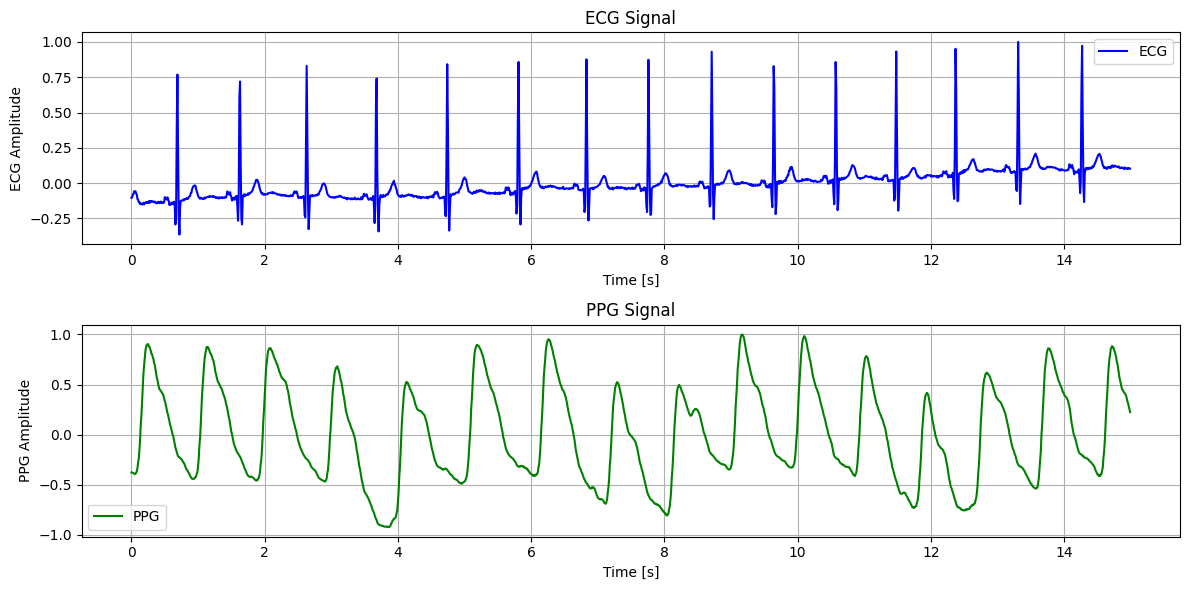

In [14]:
# Plotting Parker's ECG and PPG data

df = pd.read_csv('biosignals.csv')

# plot ECG and PPG with time
plt.figure(figsize=(12, 6))

# plot ECG
plt.subplot(2, 1, 1)
plt.plot(df['t'], df['ecg'], label='ECG', color='b')
plt.title('ECG Signal')
plt.xlabel('Time [s]')
plt.ylabel('ECG Amplitude')
plt.grid(True)
plt.legend()

# plot PPG
plt.subplot(2, 1, 2)
plt.plot(df['t'], df['ppg'], label='PPG', color='g')
plt.title('PPG Signal')
plt.xlabel('Time [s]')
plt.ylabel('PPG Amplitude')
plt.grid(True)
plt.legend()

plt.tight_layout()

plt.show()

We can use the Fourier Transform to simplify the convolution, so we can solve for $h(t)$, then use it to reconstruct $y(t)$ from $x(t)$ and compare to the original, true signal.

NOTE: One of our overall project goals is to get the h(t) "single heartbeat kernel" by itself, and then use that to recreate PPG/ECG wave data to confirm if that single heartbeat kernel is accurate in representing a heartbeats. Choosing how to represent that single heartbeat kernel is very difficult (how many paramaters should the function have, etc). In this example, we'll cheat a little bit and crop a portion of the PPG wave to simulate a single heartbeat kernel (not a very sound way to do it but will work for the purposes of this demo).

Average interval between heartbeats (sec): 0.97


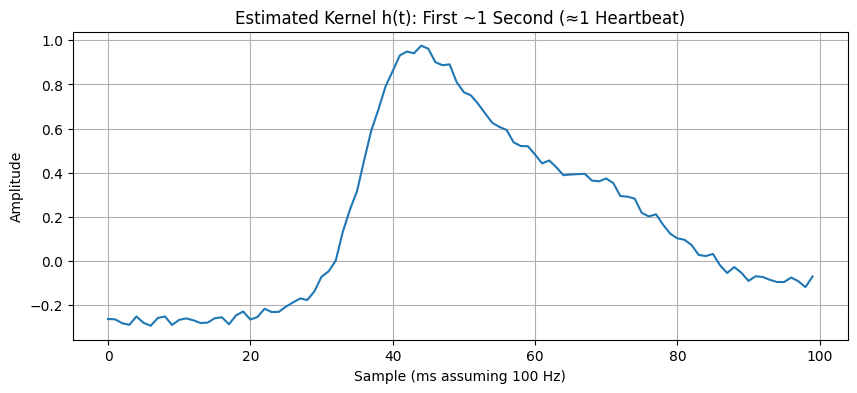

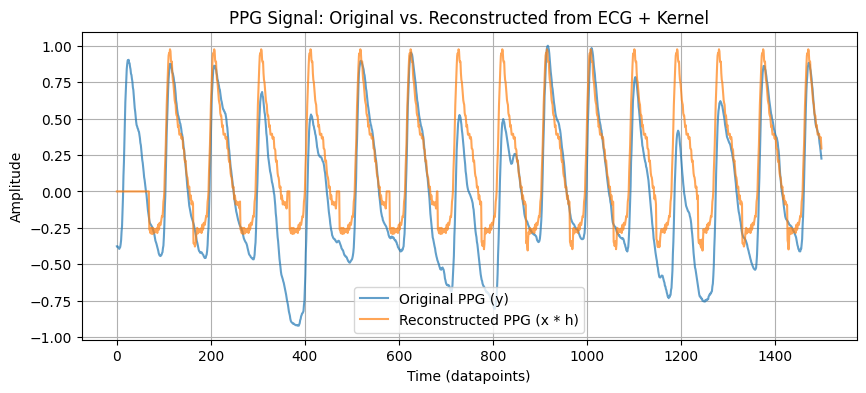

In [16]:
# Load binary ECG heart beat times: mostly 0s, with 1s at detected peaks
binary_ecg = np.loadtxt('binary_ecg_output.txt')

# Load real PPG signal
ppg = df['ppg'].values

# Step 1: Pad signals for FFT

# Pad both signals to the next power of 2 for efficient FFT (essential math detail to get FFT to work efficiently)
n = len(ppg)
N = 2 ** int(np.ceil(np.log2(n)))  # next power of 2

x_padded = np.pad(binary_ecg, (0, N - len(binary_ecg)))  # x = ECG spikes
y_padded = np.pad(ppg, (0, N - len(ppg)))                # y = PPG

# Step 2: Compute FFTs

# Get frequency domain representations
X = np.fft.fft(x_padded)  # FFT of ECG spikes
Y = np.fft.fft(y_padded)  # FFT of PPG signal

# Avoid division by near-zero values (math detail)
eps = 1e-15
X_eps = np.where(np.abs(X) < eps, eps, X)

# Step 3: Solve for H(f) = Y(f) / X(f)

# This gives the frequency-domain version of our unknown kernel h(t)
H = Y / X_eps

# Step 4: Recover h(t) with IFFT

# Get the time-domain kernel by inverting the FFT
h = np.fft.ifft(H).real  # keep only real part

# Crop to original length for comparison and viewing
h = h[:1500]

# Step 5: Extract 1 Heartbeat's Kernel

# For now, just take the first ~1 second of h(t) (about 100 samples at 100 Hz)
# This assumes h is consistent across beats
h_100 = h[:100]

# Pad it again to full length to match x_padded for reconstruction
h_100_padded = np.pad(h_100, (0, N - len(h_100)))

# Step 6: Reconstruct y(t) as x(t) * h(t) using FFT again

# Reconstruct y(t) using convolution (as multiplication in freq domain)
Y_test = np.fft.ifft(np.fft.fft(x_padded) * np.fft.fft(h_100_padded)).real

# Step 7: Estimate Average Heartbeat Interval

# we want to see what 1 h looks like, not all of them together.
# for simplicity, take the first heartbeat's h and apply it to
# the rest of the data

# Average beat spacing
heartbeat_times = np.array([0.69, 1.63, 2.63, 3.68, 4.74, 5.81, 6.83,
                            7.76, 8.71, 9.64, 10.57, 11.48, 12.37, 13.31, 14.27])

intervals = np.diff(heartbeat_times)
avg_interval = np.mean(intervals) # avg interval = .97 seconds
print(f"Average interval between heartbeats (sec): {avg_interval:.2f}")

# This gives a sense of how long a typical h(t) kernel should be
sampling_rate = 100  # Hz
avg_interval_ms = avg_interval * 1000


### Plots below ###

plt.figure(figsize=(10, 4))
plt.plot(h[:100])
plt.title("Estimated Kernel h(t): First ~1 Second (≈1 Heartbeat)")
plt.xlabel("Sample (ms assuming 100 Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 4))
plt.plot(df['ppg'], label='Original PPG (y)', alpha=0.7)
plt.plot(Y_test[:1500], label='Reconstructed PPG (x * h)', alpha=0.7)
plt.title("PPG Signal: Original vs. Reconstructed from ECG + Kernel")
plt.xlabel("Time (datapoints)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


### What to take away from this example:

- $x * h = y$ in time domain becomes $X · H = Y$ in frequency domain through the Fourier Transforma
- You can solve for $H$ by dividing $Y / X$, as long as $X$ isn’t 0 (look for eps in the example above)
    - If this math doesn't make sense, go through the equations from the "How is this helpful to us" markdown block above.
- The recovered $h(t)$ shows what 1 heartbeat “looks like” in the PPG signal
- This is pretty accurate! Thus, we see that the math works out and $x(t) * h(t)$ will (pretty nicely) recreate the observed $y(t)$, which is exactly what we set out to do!

## Summary:

### Convolutions:
$$ y(t)=x(t)*h(t) $$
Where:
- $x(t)$ = beat times (or time between beats)
- $h(t)$ = a single heartbeat
- $y(t)$ = the observed output

### Fourier Transform:
$$ Y(f) = X(f) · H(f) $$

Where solving for the unknown kernel becomes: $H(f) = \frac{Y(f)}{X(f)}$, and then we can apply the inverse fourier transform to get back $h(t)=F^{-1}(H(f))$ in the time domain, where we can then use $x(t)$ and $h(t)$ to reconstruct $y(t)$.

### Putting it all together:

We just tested a simpler forward problem:
- Assume we already know $x(t)$ (times from ECG)
- Then solve for $h(t)$ from $y(t)$

But our ultimate goal is actually the inverse of the forward probelm: to observe only $y(t)$ and recover $x(t)$ and $h(t)$ from it.

But, the real challenge is:
- Are beat times really the best way to represent $x(t)$?
- How do we actually represent $h(t)$ without just cropping it from $y(t)$? What does it look like as a function on its own? What are that function's parameters?

The numpyro_and_bayesian_inference.ipynb will help answer these questions.


​
 




